In [1]:
from utils.model import light
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn

# 检查设备信息
light.DeviceUtils.print_device_info()

🔍 设备检测结果:
   PyTorch版本: 2.7.1+cu128
   CUDA可用: ✅
   CUDA版本: 12.8
   GPU数量: 1
   GPU 0: NVIDIA GeForce RTX 4060 (8.0GB)
   MPS (Apple Silicon): ❌
   推荐设备: cuda


In [2]:
from torch._tensor import Tensor

class BetterLeNet(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            # nn.AvgPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 使用MaxPool代替AvgPool
            nn.LazyConv2d(
                16,
                kernel_size=5,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.LazyLinear(config.output_size),
        )

    def compute_loss(self, y_hat, y) -> Tensor:
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, x: Tensor):
        return self.net(x).argmax(dim=1)

    def predict_class(self, x: Tensor) -> Tensor:
        return self.predict(x).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }


In [3]:
# 移植后的使用方式
import numpy as np
from scipy.stats import rankdata
# from infonet.infer_light import load_lightning_model, load_lightning_model_alternative
from infonet.infer import load_model

# 加载预训练模型
config_path = "../../configs/infonet/config.yaml"
ckpt_path = "../../data/checkpoint/infonet_cp/model_5000_32_1000-720--0.16.pt"

# try:
model = load_model(config_path, ckpt_path)
print("✅ 使用主要方法成功加载模型")
# except Exception as e:
    # print(f"❌ 主要方法失败: {e}")
    # print("🔄 尝试备用方法...")
    # model = load_lightning_model_alternative(config_path, ckpt_path)
    # print("✅ 使用备用方法成功加载模型")
    # print(f"❌ 加载模型失败: {e}")
# model.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device)
# print(f"模型已移动到设备: {model.device}")

✅ 使用主要方法成功加载模型
使用设备: cuda


In [7]:
# 移植后的使用方式
import numpy as np
from scipy.stats import rankdata
from infonet.infer_light import load_lightning_model, load_lightning_model_alternative
# from infonet.infer import load_model

# 加载预训练模型
config_path = "../../configs/infonet/config.yaml"
ckpt_path = "../../data/checkpoint/infonet_cp/model_5000_32_1000-720--0.16.pt"

# try:
model = load_lightning_model(config_path, ckpt_path)
print("✅ 使用主要方法成功加载模型")
# except Exception as e:
#     print(f"❌ 主要方法失败: {e}")
#     print("🔄 尝试备用方法...")
#     model = load_lightning_model_alternative(config_path, ckpt_path)
#     print("✅ 使用备用方法成功加载模型")
#     print(f"❌ 加载模型失败: {e}")
model.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device)
# print(f"模型已移动到设备: {model.device}")

✅ 使用主要方法成功加载模型
使用设备: cuda


In [ ]:
datapath = "../../data/"

color_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10的RGB均值
            std=[0.2023, 0.1994, 0.2010],  # CIFAR-10的RGB标准差
        ),
    ]
)
# 加载 CIFAR-10 数据集
cifar10_train = datasets.CIFAR10(
    root=datapath, train=True, download=True, transform=color_transforms
)

cifar10_test = datasets.CIFAR10(
    root=datapath,
    train=False,
    download=True,
    transform=color_transforms,  # 测试时不使用数据增强
)

# 创建数据加载器
train_loader = DataLoader(
    cifar10_train, 
    batch_size=128, 
    shuffle=True, 
)

val_loader = DataLoader(
    cifar10_test, 
    batch_size=128, 
    shuffle=False, 
)

num_classes = 10  # CIFAR-10 有10个类别
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 数据集类别数: {num_classes}")
print(f"类别名称: {class_names}")
print(f"训练集大小: {len(cifar10_train)}")
print(f"测试集大小: {len(cifar10_test)}")
# 加载器手动移动到gpu设备
def move_to_device(loader, device):
    for batch in loader:
        if isinstance(batch, dict):
            yield {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        elif isinstance(batch, (tuple, list)):
            yield tuple(v.to(device) if isinstance(v, torch.Tensor) else v for v in batch)
        else:
            yield batch
# 将数据加载器中的数据移动到设备
train_loader = move_to_device(train_loader, device)
val_loader = move_to_device(val_loader, device)
# 查看是否成功移动到设备上
first_train_batch = next(iter(train_loader))
first_val_batch = next(iter(val_loader))
if isinstance(first_train_batch, (tuple, list)):
    print(f"训练集加载器设备: {first_train_batch[0].device}")
else:
    print(f"训练集加载器设备: {first_train_batch.device}")
if isinstance(first_val_batch, (tuple, list)):
    print(f"验证集加载器设备: {first_val_batch[0].device}")
else: 
    print(f"验证集加载器设备: {first_val_batch.device}")


CIFAR-10 数据集类别数: 10
类别名称: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
训练集大小: 50000
测试集大小: 10000
训练集加载器设备: cuda:0
验证集加载器设备: cuda:0


In [9]:
# 创建普通的LeNet模型
from utils.model import callback


config = light.ModelConfig(
    lr=0.001,
    num_hiddens=256,
    output_size=num_classes,
    optimizer="adam",
    weight_decay=0.0001,  
)
model_lenet = BetterLeNet(config)  # 使用原始的简洁LeNet
mi_callback = callback.FilePersistentMutualInformationCallback(
    mi_model=model,
    eval_loader=val_loader,
    eval_every_n_epochs=1,
    save_dir="./mi_analysis",  # 结果保存目录
    experiment_name="lenet_cifar10_v2"  # 实验名称
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model_lenet = model_lenet.to(device)
print(f"模型已移动到设备: {model_lenet.device}")
for name, param in model.named_parameters():
    print(f"{name}: {param.device}")
    
print("\n")
for name, param in model_lenet.named_parameters():
    print(f"{name}: {param.device}")
    

✅ MI结果将保存到: ./mi_analysis\lenet_cifar10_v2_mi_results.csv
📊 汇总报告: ./mi_analysis\lenet_cifar10_v2_summary.txt
🔬 使用InfoNet进行MI估计 (seq_len=2000, proj_num=1024)
使用设备: cuda
模型已移动到设备: cuda:0
model.encoder.latents: cuda:0
model.encoder.cross_attn_block.cross_attention.q_norm.weight: cuda:0
model.encoder.cross_attn_block.cross_attention.q_norm.bias: cuda:0
model.encoder.cross_attn_block.cross_attention.kv_norm.weight: cuda:0
model.encoder.cross_attn_block.cross_attention.kv_norm.bias: cuda:0
model.encoder.cross_attn_block.cross_attention.attention.qeury.weight: cuda:0
model.encoder.cross_attn_block.cross_attention.attention.qeury.bias: cuda:0
model.encoder.cross_attn_block.cross_attention.attention.key.weight: cuda:0
model.encoder.cross_attn_block.cross_attention.attention.key.bias: cuda:0
model.encoder.cross_attn_block.cross_attention.attention.value.weight: cuda:0
model.encoder.cross_attn_block.cross_attention.attention.value.bias: cuda:0
model.encoder.cross_attn_block.cross_attention.attent

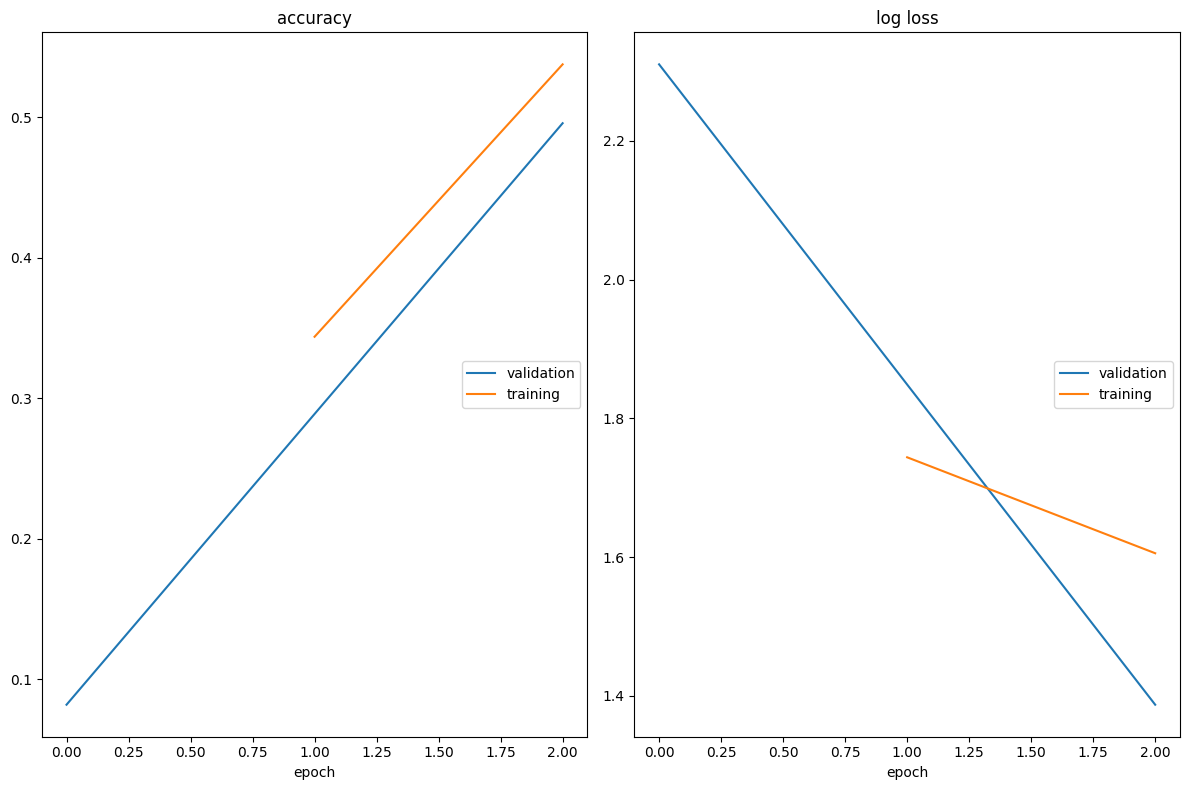

accuracy
	validation       	 (min:    0.082, max:    0.496, cur:    0.496)
	training         	 (min:    0.344, max:    0.538, cur:    0.538)
log loss
	validation       	 (min:    1.387, max:    2.310, cur:    1.387)
	training         	 (min:    1.605, max:    1.744, cur:    1.605)
Epoch 0: |          | 390/? [00:14<00:00, 27.31it/s, v_num=23, train_loss=1.350, train_acc=0.538, val_loss=1.390, val_acc=0.496]🔍 Epoch 0 - InfoNet MI分析中...
Epoch 1: |          | 0/? [00:00<?, ?it/s, v_num=23, train_loss=1.350, train_acc=0.538, val_loss=1.390, val_acc=0.496]          🔍 Epoch 1 - InfoNet MI分析中...
Epoch 2: |          | 0/? [00:00<?, ?it/s, v_num=23, train_loss=1.350, train_acc=0.538, val_loss=1.390, val_acc=0.496]🔍 Epoch 2 - InfoNet MI分析中...
Epoch 3: |          | 0/? [00:00<?, ?it/s, v_num=23, train_loss=1.350, train_acc=0.538, val_loss=1.390, val_acc=0.496]🔍 Epoch 3 - InfoNet MI分析中...
Epoch 4: |          | 0/? [00:00<?, ?it/s, v_num=23, train_loss=1.350, train_acc=0.538, val_loss=1.390, val_ac

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: |          | 0/? [00:00<?, ?it/s, v_num=23, train_loss=1.350, train_acc=0.538, val_loss=1.390, val_acc=0.496]


In [10]:
live_callback = callback.EnhancedHighFrequencyLiveLossPlotCallback(
    update_every_n_batches=200
)

trainer = light.TrainerFactory.basic(
    max_epochs=10,
)
    
trainer.add_callback(mi_callback)
trainer.add_callback(live_callback)

trainer.fit(
    model_lenet, 
    train_loader=train_loader, 
    val_loader=val_loader
)